# 08: Thunderstorm Wind Average Magnitude Forecast | Region: U.S. Mainland
---

## 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

pd.set_option('display.max_columns', None)

---
## 2. Loading Data

In [2]:
all_storms = pd.read_csv('../data/all_storms_dt_damage_clean.csv')

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
## 3. Organizing Data

### 3.1. Dropping Columns

In [3]:
all_storms = all_storms[['state', 'region', 'event_type', 'begin_date_time', 'magnitude']]

In [4]:
all_storms

,state,region,event_type,begin_date_time,magnitude
0,Oklahoma,South,Tornado,1950-04-28 14:45:00,0.0
1,Texas,South,Tornado,1950-06-19 20:40:00,0.0
2,Indiana,Midwest,Tornado,1950-07-19 14:30:00,0.0
3,Indiana,Midwest,Tornado,1950-07-19 17:45:00,0.0
4,Colorado,West,Tornado,1950-07-22 15:07:00,0.0
...,...,...,...,...,...
1740591,Arkansas,South,Winter Storm,2022-02-02 18:45:00,NaN
1740592,Arkansas,South,Winter Weather,2022-02-03 02:50:00,NaN
1740593,Arkansas,South,Winter Storm,2022-02-03 01:00:00,NaN
1740594,Massachusetts,Northeast,Heavy Snow,2022-02-25 00:00:00,NaN


In [5]:
# Casting the begin_date_time to a datetime dtype
all_storms['begin_date_time'] = pd.to_datetime(all_storms['begin_date_time'])

# Setting begin_date_time as the index
all_storms.set_index('begin_date_time', inplace=True)

# Sorting the index
all_storms.sort_index(inplace=True)

In [6]:
# Dropping all rows with a missing value in the magnitude column

all_storms = all_storms.dropna(subset=['magnitude'])

### 3.2. Subsetting to Thunderstorm Wind in all U.S. mainland regions (2000-2022)

In [7]:
ts_wind = all_storms[all_storms['event_type'] == 'Thunderstorm Wind']

ts_wind = ts_wind[ts_wind['region'].isin(['Midwest', 'South', 'Northeast', 'West'])]

ts_wind = ts_wind[ts_wind.index > '2000']

In [8]:
ts_wind

,state,region,event_type,magnitude
begin_date_time,,,,
2000-01-02 16:33:00,Arkansas,South,Thunderstorm Wind,50.0
2000-01-02 17:15:00,Arkansas,South,Thunderstorm Wind,50.0
2000-01-03 00:25:00,Tennessee,South,Thunderstorm Wind,50.0
2000-01-03 04:26:00,Oklahoma,South,Thunderstorm Wind,52.0
2000-01-03 04:34:00,Arkansas,South,Thunderstorm Wind,52.0
...,...,...,...,...
2022-03-31 19:23:00,Pennsylvania,Northeast,Thunderstorm Wind,52.0
2022-03-31 19:36:00,Pennsylvania,Northeast,Thunderstorm Wind,50.0
2022-03-31 19:59:00,Maryland,South,Thunderstorm Wind,55.0


### 3.3. Resampling to Quarterly Averages

In [9]:
# Helper plotting function

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
   
    plt.figure(figsize=(10,6))
    
    for col in cols:
        plt.plot(df[col])

    plt.title(title, fontsize=14)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12);

In [10]:
# Resampling to quarterly averages
ts_wind = ts_wind.resample('Q').mean()

# Renaming the column to 'avg_mag'
ts_wind = ts_wind.rename(columns={'magnitude': 'avg_mag'})

In [11]:
# Checking for null values as a result of the resampling

ts_wind.isnull().sum()

avg_mag    0
dtype: int64

In [12]:
ts_wind

,avg_mag
begin_date_time,
2000-03-31,55.440289
2000-06-30,55.292212
2000-09-30,55.127660
2000-12-31,56.291169
2001-03-31,55.013393
...,...
2021-03-31,53.669786
2021-06-30,53.454758
2021-09-30,53.036626


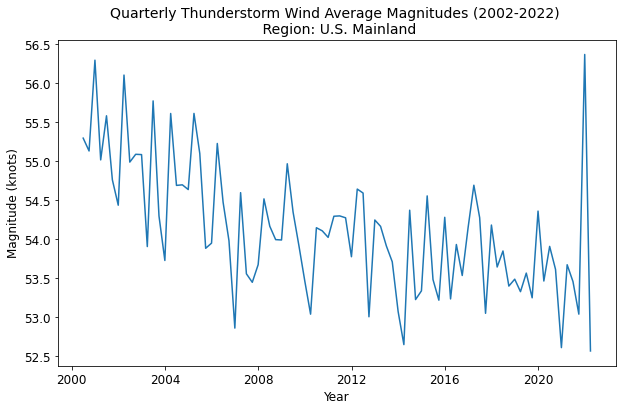

In [28]:
# Quarterly Thunderstorm Wind Average Magnitudes (2002-2022) - Region: U.S. Mainland

plot_series(ts_wind, ['avg_mag'], title='Quarterly Thunderstorm Wind Average Magnitudes (2002-2022) \n Region: U.S. Mainland', xlab='Year', ylab='Magnitude (knots)', steps=4)

---
## 4. Trends

### 4.1. Seasonality

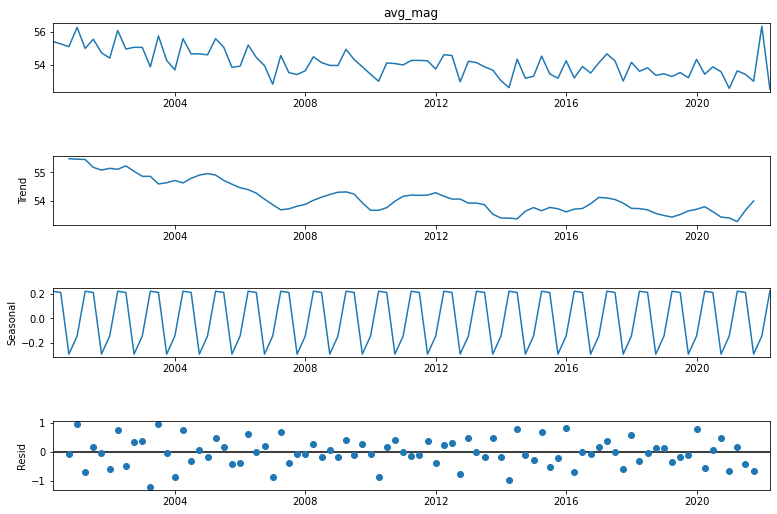

In [14]:
decomp = seasonal_decompose(ts_wind['avg_mag'])

decomp.plot();
fig = plt.gcf()
fig.set_size_inches(12, 8)

In the trend component, we see a decreasing trend.

In the seasonal component, we see that there appears to be some seasonality detected. But this seasonal view can sometimes be misleading, so I'll need to run some additional diagnostics.

In the resid component, we see that there's quite a bit of variability that can not be explained by the model.

### 4.2. Autocorrelation

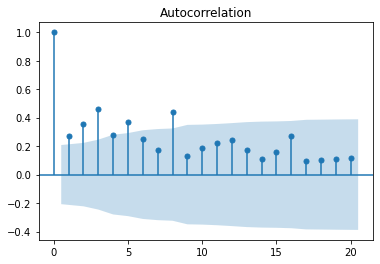

In [15]:
plot_acf(ts_wind['avg_mag']);

For trend, the first 3 lags all extend beyond the blue region, which represents a 95% confidence interval. This confirms that there is a trend present in the data.

For seasonality, the fluctuations do not seem to occur with a fixed and known frequency and therefore, indicates that there is likely no seasonality present in the data.

For lags, it seems that the first 3 lags will be useful to include in the model.

### 4.3. Partial Autocorrelation

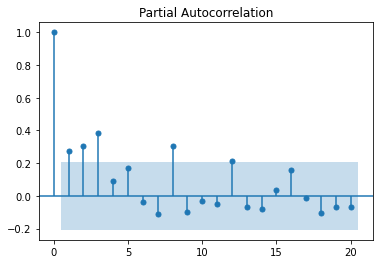

In [16]:
plot_pacf(ts_wind['avg_mag']);

For seasonality, contrary to the autocorrelation, the fluctuations no longer occur with a fixed and known frequency and therefore, determines that there is no seasonality present.

For lags, it still seems that the first lag will be useful to include in the model.

### 4.4. Stationarity

In [17]:
# Dickey-Fuller Stationarity Test

adfuller(ts_wind['avg_mag'])

(-2.312526301377624,
 0.16795981123763992,
 11,
 77,
 {'1%': -3.518281134660583,
  '5%': -2.899878185191432,
  '10%': -2.5872229937594873},
 156.30726371143763)

The first 2 statistics of the test results tell me that the data is not stationary.

The 'test statistic', the first statistic, needs to be less than the critical values, which are the 1%, 5% and 10% values, and it is not. The p-value, the second statistic, needs to be less than the alpha of 0.05, and it is not. As a result, I'll need to difference the data.

### 4.5. Differencing

#### 4.5.1. Once Differenced

In [18]:
# Differencing the data

ts_wind['first_diff'] = ts_wind['avg_mag'].diff()

In [19]:
# Dropping any null values as a result of the differencing

ts_wind.dropna(inplace=True)

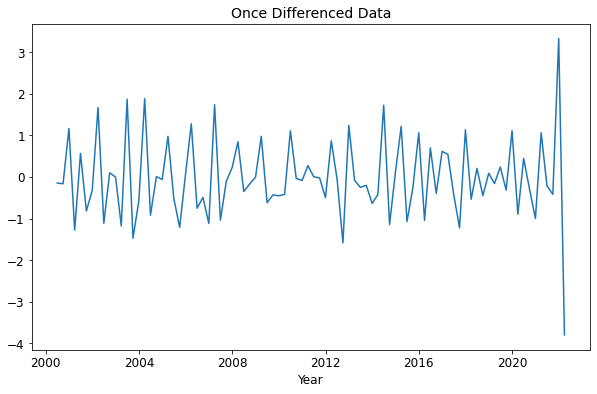

In [20]:
plot_series(ts_wind, ['first_diff'], title='Once Differenced Data', xlab='Year', steps=4)

In [21]:
# Checking for the stationarity of the once differenced data

adfuller(ts_wind['first_diff'])

(-6.096525616674891,
 1.0069774828441526e-07,
 6,
 81,
 {'1%': -3.5137900174243235,
  '5%': -2.8979433868293945,
  '10%': -2.5861907285474777},
 157.8285722105827)

The test statistic is now less than the critical values and the p-value is less than the alpha of 0.05. The data is now stationary and can be modeled on with ARIMA.

---
## 5. ARIMA Time Series Modeling

### 5.1. Train-Test Split

In [22]:
y_train, y_test = train_test_split(ts_wind['first_diff'], test_size=0.1, shuffle=False)

### 5.2. GridSearch for best AIC, p & q

Because I needed to difference the data twice, I know that the d parameter for the ARIMA model is 1. Given that, I'll run a GridSearch for the most optimal p & q.

In [23]:
best_aic = 1_000_000_000
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order=(p, 1, q))
            
            model = arima.fit(method_kwargs={"warn_convergence": False})

            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q

        except Exception as e:
            print(e)
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

The AIC for ARIMA(0,1,0) is: 281.06611981990864
The AIC for ARIMA(0,1,1) is: 203.52144105535456
The AIC for ARIMA(0,1,2) is: 158.95299732478637


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(0,1,3) is: 160.92156623851622
The AIC for ARIMA(0,1,4) is: 162.7032207571373
The AIC for ARIMA(1,1,0) is: 246.5584428228979
The AIC for ARIMA(1,1,1) is: 185.80894896212376
The AIC for ARIMA(1,1,2) is: 160.92604037369242
The AIC for ARIMA(1,1,3) is: 162.68872012874692
The AIC for ARIMA(1,1,4) is: 164.6322137682158
The AIC for ARIMA(2,1,0) is: 213.1926396728147
The AIC for ARIMA(2,1,1) is: 168.19052869556032
The AIC for ARIMA(2,1,2) is: 162.20827445756788
The AIC for ARIMA(2,1,3) is: 164.66314609239566
The AIC for ARIMA(2,1,4) is: 157.26653884277178
The AIC for ARIMA(3,1,0) is: 202.27639276207583
The AIC for ARIMA(3,1,1) is: 166.21687900393593
The AIC for ARIMA(3,1,2) is: 169.97715351491775
The AIC for ARIMA(3,1,3) is: 165.90461596606687
The AIC for ARIMA(3,1,4) is: 157.42271572264914
The AIC for ARIMA(4,1,0) is: 185.07216623215012
The AIC for ARIMA(4,1,1) is: 163.5206870823222
The AIC for ARIMA(4,1,2) is: 165.49525894009057
The AIC for ARIMA(4,1,3) is: 161.977540813099

The p, d, q combination that returned the lowest AIC was when p=2, d=1, and q=4. This means that the model will perform best with the use of 2 lags, once differenced data, and a moving average window of 4. As such, the order of (2,1,4) will be used in the ARIMA model.

### 5.3. Instantiate & Fit

In [52]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (2,1,4))

arima = model.fit()

### 5.4. Test Forecast

In [53]:
# Checking how many quarters were considered as test data with a test size of 10%

len(y_test)

9

In [54]:
# Generating the forecast for those 8 quarters

forecast = arima.forecast(steps=9)
forecast

2020-03-31   -0.469571
2020-06-30   -0.226940
2020-09-30    0.099051
2020-12-31    0.037827
2021-03-31   -0.169903
2021-06-30    0.206062
2021-09-30   -0.179457
2021-12-31    0.064979
2022-03-31    0.046231
Freq: Q-DEC, Name: predicted_mean, dtype: float64

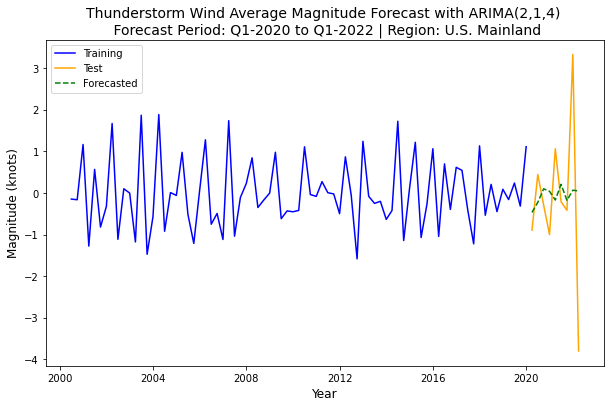

In [55]:
# Thunderstorm Wind Average Magnitude Forecast with ARIMA(2,1,4) - Forecast Period: Q1-2020 to Q1-2022 | Region: U.S. Mainland

plt.figure(figsize=(10,6))
plt.plot(y_train.index, y_train, color='blue', label='Training')
plt.plot(y_test.index, y_test, color='orange', label='Test')
plt.plot(y_test.index, forecast, color='green', label='Forecasted', linestyle='--')

plt.title(label = 'Thunderstorm Wind Average Magnitude Forecast with ARIMA(2,1,4) \n Forecast Period: Q1-2020 to Q1-2022 | Region: U.S. Mainland', fontsize=14)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Magnitude (knots)', fontsize=12)

plt.legend();

Visually, the model does not seem to have forecasted well. It intially does try to follow the increases and decreases, but the last 

### 5.5. Test Evaluation

In [29]:
r2 = r2_score(y_test, forecast)
print('R2: ' + str(r2))

R2: -0.01617542321511989


The model is able to explain 12% of the variability in the data.

In [30]:
rmse = mean_squared_error(y_test, forecast, squared=False)
print('RMSE: ' + str(rmse))

RMSE: 1.796789487033949


In [32]:
ts_wind.describe()

,avg_mag,first_diff
count,88.000000,88.000000
mean,54.132233,-0.032676
std,0.826949,0.986202
min,52.564822,-3.799529
25%,53.520277,-0.519880
50%,54.062215,-0.154029
75%,54.603506,0.547867
max,56.364350,3.327724


The RMSE of 1.79 exceeded the standard deviation of 0.98. This means that this model's forecasts are not reliable.

## 6. Thunderstorm Wind Conclusion

At the national level, the model was able to explain -2% of the variability, and did not produce a reliable forecast according to the RMSE (1.80) and standard deviation (0.99) comparison. This indicates that there are high amounts of natural variability in the data, and it is difficult to forecast reliably at the national level.

The models at the regional level did not fare much better in terms of explaining the amount of variability, though, the Northeast and West regions did produce a reliable forecast.

- **Midwest**
    - The model explained -4% of the variability
    - Did not produce a reliable forecast, according to the RMSE (1.49) and standard deviation (1.32) comparison
- **South**
    - The model explained 10% of the variability
    - Did not produce a reliable forecast, according to the RMSE (2.37) and standard deviation (2.12) comparison
- **Northeast**
    - The model explained 4% of the variability
    - Produced a reliable forecast, according to the RMSE (1.28) and standard deviation (1.52) comparison
- **West**
    - The model explained -30% of the variability
    - Produced a reliable forecast, according to the RMSE (2.16) and standard deviation (2.66) comparison